In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
# 📂 데이터 로딩
label_train = pd.read_csv("./data/train/label/1.걸음걸이/train_label.csv")
activity_train = pd.read_csv("./data/train/raw/train_activity.csv")
sleep_train = pd.read_csv("./data/train/raw/train_sleep.csv")
label_val = pd.read_csv("./data/validation/label/1.걸음걸이/validation_label.csv")
activity_val = pd.read_csv("./data/validation/raw/validation_activity.csv")
sleep_val = pd.read_csv("./data/validation/raw/validation_sleep.csv")

# Data Split

In [4]:
# 전체 라벨 데이터 로드
label_df = pd.concat([label_train, label_val])

# CN, MCI, Dem 그룹 분리
cn_df = label_df[label_df["DIAG_NM"] == "CN"].drop_duplicates("SAMPLE_EMAIL")
mci_df = label_df[label_df["DIAG_NM"] == "MCI"].drop_duplicates("SAMPLE_EMAIL")
dem_df = label_df[label_df["DIAG_NM"] == "Dem"].drop_duplicates("SAMPLE_EMAIL")

# 각각 stratified split (8:2)
cn_train, cn_test = train_test_split(cn_df, test_size=0.2, random_state=42)
mci_train, mci_test = train_test_split(mci_df, test_size=0.2, random_state=42)
dem_train, dem_test = train_test_split(dem_df, test_size=0.2, random_state=42)

# train/test set 결합
train_df = pd.concat([cn_train, mci_train, dem_train], ignore_index=True)
test_df = pd.concat([cn_test, mci_test, dem_test], ignore_index=True)

# 비정상군(MCI + Dem) 마킹
train_df["label"] = train_df["DIAG_NM"].replace({"CN": "Normal", "MCI": "Abnormal", "Dem": "Abnormal"})
test_df["label"] = test_df["DIAG_NM"].replace({"CN": "Normal", "MCI": "Abnormal", "Dem": "Abnormal"})

# ✅ 분포 확인
print("Train 분포:\n", train_df["label"].value_counts())
print("Test 분포:\n", test_df["label"].value_counts())

Train 분포:
 label
Normal      88
Abnormal    49
Name: count, dtype: int64
Test 분포:
 label
Normal      23
Abnormal    14
Name: count, dtype: int64


In [5]:
activity_df = pd.concat([activity_train, activity_val], axis=0)
sleep_df = pd.concat([sleep_train, sleep_val], axis=0)

In [6]:
activity_train = activity_df[activity_df['EMAIL'].isin(train_df['SAMPLE_EMAIL'])]
activity_val = activity_df[activity_df['EMAIL'].isin(test_df['SAMPLE_EMAIL'])]
sleep_train = sleep_df[sleep_df['EMAIL'].isin(train_df['SAMPLE_EMAIL'])]
sleep_val = sleep_df[sleep_df['EMAIL'].isin(test_df['SAMPLE_EMAIL'])]
label_val = test_df[["SAMPLE_EMAIL", "DIAG_NM"]]
label_train = train_df[["SAMPLE_EMAIL", "DIAG_NM"]]

In [7]:
activity_sorted_train = activity_train.sort_values(['EMAIL', 'activity_day_start']).reset_index(drop=True)
sleep_sorted_train = sleep_train.sort_values(['EMAIL', 'sleep_bedtime_start']).reset_index(drop=True)
sleep_sorted_train = sleep_sorted_train.drop(columns=['EMAIL'])
merged_df_train = pd.concat([activity_sorted_train, sleep_sorted_train], axis=1)

In [8]:
activity_sorted_val = activity_val.sort_values(['EMAIL', 'activity_day_start']).reset_index(drop=True)
sleep_sorted_val = sleep_val.sort_values(['EMAIL', 'sleep_bedtime_start']).reset_index(drop=True)
sleep_sorted_val = sleep_sorted_val.drop(columns=['EMAIL'])
merged_df_val = pd.concat([activity_sorted_val, sleep_sorted_val], axis=1)

In [9]:
label_train.to_csv("./data/base/train_label.csv")
activity_train.to_csv("./data/base/train_activity.csv")
sleep_train.to_csv("./data/base/train_sleep.csv")
merged_df_train.to_csv("./data/base/train_merged.csv")
label_val.to_csv("./data/base/validation_label.csv")
activity_val.to_csv("./data/base/validation_activity.csv")
sleep_val.to_csv("./data/base/validation_sleep.csv")
merged_df_val.to_csv('./data/base/validation_merged.csv')

# 로그 데이터 컬럼명 변경

In [10]:
# 🔁 복사본 생성
merged_train = merged_df_train.copy()
merged_val = merged_df_val.copy()

# 🔁 sleep 컬럼 정리
merged_train.drop(columns=['sleep_hr_5min', 'sleep_hypnogram_5min', 'sleep_rmssd_5min'], inplace=True)
merged_val.drop(columns=['sleep_hr_5min', 'sleep_hypnogram_5min', 'sleep_rmssd_5min'], inplace=True)

merged_train.rename(columns={
    'CONVERT(sleep_hr_5min USING utf8)': 'sleep_hr_5min',
    'CONVERT(sleep_hypnogram_5min USING utf8)': 'sleep_hypnogram_5min',
    'CONVERT(sleep_rmssd_5min USING utf8)': 'sleep_rmssd_5min'
}, inplace=True)

merged_val.rename(columns={
    'CONVERT(sleep_hr_5min USING utf8)': 'sleep_hr_5min',
    'CONVERT(sleep_hypnogram_5min USING utf8)': 'sleep_hypnogram_5min',
    'CONVERT(sleep_rmssd_5min USING utf8)': 'sleep_rmssd_5min'
}, inplace=True)

# 🔁 activity 컬럼 정리
merged_train.drop(columns=['activity_class_5min', 'activity_met_1min'], inplace=True)
merged_val.drop(columns=['activity_class_5min', 'activity_met_1min'], inplace=True)

merged_train.rename(columns={
    'CONVERT(activity_class_5min USING utf8)': 'activity_class_5min',
    'CONVERT(activity_met_1min USING utf8)': 'activity_met_1min',
}, inplace=True)

merged_val.rename(columns={
    'CONVERT(activity_class_5min USING utf8)': 'activity_class_5min',
    'CONVERT(activity_met_1min USING utf8)': 'activity_met_1min',
}, inplace=True)

# sleep_hr_5min 선형보간
- 0값(결측치)들을 선형보간


In [11]:
# 0. 복사본 생성 (경고 방지)
merged_train = merged_train.copy()
merged_val = merged_val.copy()

# 1. sleep_hr_5min 파싱 함수 (0 포함)
def parse_hr(row):
    try:
        return [float(x) for x in row.split('/') if x.strip() != '']
    except:
        return []

# 2. 파싱
merged_train.loc[:, "sleep_hr_5min"] = merged_train["sleep_hr_5min"].apply(parse_hr)
merged_val.loc[:, "sleep_hr_5min"] = merged_val["sleep_hr_5min"].apply(parse_hr)

# 3. Heart Rate = 0인 값 개수 세기
merged_train.loc[:, "hr_zero_count"] = merged_train["sleep_hr_5min"].apply(lambda x: sum(1 for v in x if v == 0))
merged_val.loc[:, "hr_zero_count"] = merged_val["sleep_hr_5min"].apply(lambda x: sum(1 for v in x if v == 0))

# 4. 통계 출력
print("==== train ====")
print("💡 Heart Rate = 0 값 분포")
print(merged_train["hr_zero_count"].describe())

print("\n📌 0값이 포함된 샘플 수:", (merged_train["hr_zero_count"] > 0).sum())
print("📌 전체 샘플 수:", len(merged_train))
print("📌 비율 (%):", round((merged_train["hr_zero_count"] > 0).mean() * 100, 2), "%")

==== train ====
💡 Heart Rate = 0 값 분포
count    9557.000000
mean       11.277388
std        11.033643
min         0.000000
25%         3.000000
50%         8.000000
75%        15.000000
max        89.000000
Name: hr_zero_count, dtype: float64

📌 0값이 포함된 샘플 수: 9370
📌 전체 샘플 수: 9557
📌 비율 (%): 98.04 %


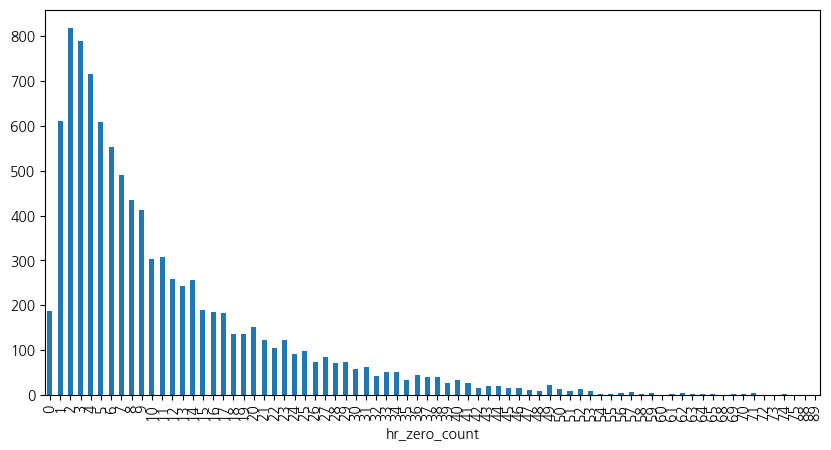

In [12]:
merged_train['hr_zero_count'].value_counts().sort_index().plot(kind='bar', figsize=(10, 5));

In [13]:
# 1. 연속된 0의 최대 길이를 계산하는 함수
def max_consecutive_zeros(hr_list):
    max_streak = 0
    current_streak = 0
    for val in hr_list:
        if val == 0:
            current_streak += 1
            max_streak = max(max_streak, current_streak)
        else:
            current_streak = 0
    return max_streak

print("====train====")

# 2. 0이 50개 이상 포함된 행 필터링
high_zero_df = merged_train[merged_train["hr_zero_count"] >= 50].copy()

# 3. 연속된 0의 최대 길이 및 총 로그 수 계산
high_zero_df["max_zero_streak"] = high_zero_df["sleep_hr_5min"].apply(max_consecutive_zeros)
high_zero_df["total_log_count"] = high_zero_df["sleep_hr_5min"].apply(len)

# 4. 결과 요약
print(f"⚠️ 0값 50개 이상인 샘플 수: {len(high_zero_df)}")
print("\n📊 연속된 0의 최대 길이 통계:")
print(high_zero_df["max_zero_streak"].describe())

# 출력
print("\n📌 연속된 0의 길이 높은 순")
display(high_zero_df[["EMAIL", "hr_zero_count", "max_zero_streak", "total_log_count"]].sort_values(by="max_zero_streak", ascending=False))

====train====
⚠️ 0값 50개 이상인 샘플 수: 98

📊 연속된 0의 최대 길이 통계:
count    98.000000
mean     18.918367
std       7.880124
min       5.000000
25%      13.000000
50%      17.000000
75%      24.000000
max      44.000000
Name: max_zero_streak, dtype: float64

📌 연속된 0의 길이 높은 순


,EMAIL,hr_zero_count,max_zero_streak,total_log_count
3062,nia+139@rowan.kr,62,44,139
7044,nia+331@rowan.kr,52,38,126
374,nia+015@rowan.kr,51,38,107
5668,nia+268@rowan.kr,70,34,181
8260,nia+371@rowan.kr,63,33,131
...,...,...,...,...
5658,nia+268@rowan.kr,52,9,139
4163,nia+196@rowan.kr,53,9,145
4802,nia+229@rowan.kr,70,9,181
6077,nia+283@rowan.kr,53,7,111


## 로그 중 30% 이상 연속된 0 구간이 있는 행 제거

In [14]:
# 0. 복사본 생성 (경고 방지)
merged_train = merged_train.copy()
merged_val = merged_val.copy()

# 1. 연속된 0의 최대 길이를 계산하는 함수
def max_consecutive_zeros(hr_list):
    max_streak = 0
    current_streak = 0
    for val in hr_list:
        if val == 0:
            current_streak += 1
            max_streak = max(max_streak, current_streak)
        else:
            current_streak = 0
    return max_streak

print("====train====")

# 2. 연속된 0의 최대 길이 및 총 로그 수 계산
merged_train["max_zero_streak"] = merged_train["sleep_hr_5min"].apply(max_consecutive_zeros)
merged_train["total_log_count"] = merged_train["sleep_hr_5min"].apply(len)

print(f"⚠️ 제거된 샘플 수: {len(merged_train)}")

# 3. 30% 이상 연속된 0 구간이 있는 행 제거 대상 필터링
merged_train = merged_train[merged_train["max_zero_streak"] / merged_train["total_log_count"] < 0.3]

print(f"✅ 제거 후 남은 샘플 수: {len(merged_train)}")

print("\n====test====")

# 2. 연속된 0의 최대 길이 및 총 로그 수 계산
merged_val["max_zero_streak"] = merged_val["sleep_hr_5min"].apply(max_consecutive_zeros)
merged_val["total_log_count"] = merged_val["sleep_hr_5min"].apply(len)

print(f"⚠️ 제거된 샘플 수: {len(merged_val)}")

# 3. 30% 이상 연속된 0 구간이 있는 행 제거 대상 필터링
merged_val = merged_val[merged_val["max_zero_streak"] / merged_val["total_log_count"] < 0.3]

print(f"✅ 제거 후 남은 샘플 수: {len(merged_val)}")

====train====
⚠️ 제거된 샘플 수: 9557
✅ 제거 후 남은 샘플 수: 9548

====test====
⚠️ 제거된 샘플 수: 2626
✅ 제거 후 남은 샘플 수: 2625


In [15]:
# 2. 선형 보간 함수: 0을 np.nan으로 바꾸고 interpolate
def interpolate_hr(hr_list):
    arr = np.array(hr_list, dtype='float')
    arr[arr == 0] = np.nan  # 0을 NaN으로 대체
    series = pd.Series(arr).interpolate(method='linear', limit_direction='both')
    return series.tolist()

# 3. 적용
merged_train["sleep_hr_5min_interpolated"] = merged_train["sleep_hr_5min"].apply(interpolate_hr)
merged_val["sleep_hr_5min_interpolated"] = merged_val["sleep_hr_5min"].apply(interpolate_hr)

- 선형 보간 후 검증

In [16]:
merged_train["zero_count_before"] = merged_train["sleep_hr_5min"].apply(lambda x: sum(v == 0 for v in x))
merged_train["zero_count_after"] = merged_train["sleep_hr_5min_interpolated"].apply(lambda x: sum(v == 0 for v in x))

merged_val["zero_count_before"] = merged_val["sleep_hr_5min"].apply(lambda x: sum(v == 0 for v in x))
merged_val["zero_count_after"] = merged_val["sleep_hr_5min_interpolated"].apply(lambda x: sum(v == 0 for v in x))

print("✅ Train Set 0값 개수 변화:")
print(merged_train[["zero_count_before", "zero_count_after"]].describe())

print("\n✅ Validation Set 0값 개수 변화:")
print(merged_val[["zero_count_before", "zero_count_after"]].describe())

✅ Train Set 0값 개수 변화:
       zero_count_before  zero_count_after
count        9548.000000            9548.0
mean           11.248848               0.0
std            10.994741               0.0
min             0.000000               0.0
25%             3.000000               0.0
50%             7.000000               0.0
75%            15.000000               0.0
max            89.000000               0.0

✅ Validation Set 0값 개수 변화:
       zero_count_before  zero_count_after
count        2625.000000            2625.0
mean           11.508190               0.0
std            11.472463               0.0
min             0.000000               0.0
25%             4.000000               0.0
50%             7.000000               0.0
75%            16.000000               0.0
max            85.000000               0.0


# sleep_rmssd_5min 선형보간

- 0값(결측치)들을 선형보간

In [17]:
# 1. sleep_rmssd_5min 파싱 함수 (0 포함)
def parse_rmssd(row):
    try:
        return [float(x) for x in row.split('/') if x.strip() != '']
    except:
        return []

# 2. 파싱
merged_train["sleep_rmssd_5min"] = merged_train["sleep_rmssd_5min"].apply(parse_rmssd)
merged_val["sleep_rmssd_5min"] = merged_val["sleep_rmssd_5min"].apply(parse_rmssd)

# 3. 각 row에서 heart rate가 0인 값의 개수 세기
merged_train["rmssd_zero_count"] = merged_train["sleep_rmssd_5min"].apply(lambda x: sum(1 for v in x if v == 0))
merged_val["rmssd_zero_count"] = merged_val["sleep_rmssd_5min"].apply(lambda x: sum(1 for v in x if v == 0))

# 4. 통계 출력
print("====train====")
print("💡 Heart Rate = 0 값 분포")
print(merged_train["rmssd_zero_count"].describe())

print("\n📌 0값이 포함된 샘플 수:", (merged_train["rmssd_zero_count"] > 0).sum())
print("📌 전체 샘플 수:", len(merged_train))
print("📌 비율 (%):", round((merged_train["rmssd_zero_count"] > 0).mean() * 100, 2), "%")

====train====
💡 Heart Rate = 0 값 분포
count    9548.000000
mean       11.248848
std        10.994741
min         0.000000
25%         3.000000
50%         7.000000
75%        15.000000
max        89.000000
Name: rmssd_zero_count, dtype: float64

📌 0값이 포함된 샘플 수: 9361
📌 전체 샘플 수: 9548
📌 비율 (%): 98.04 %


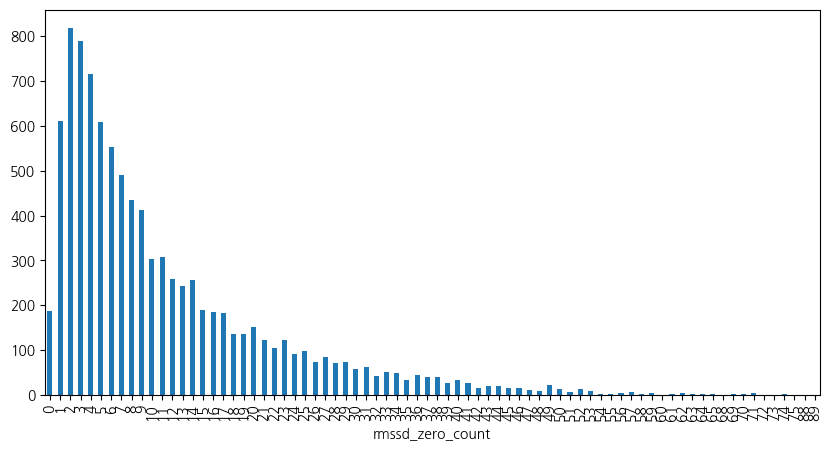

In [18]:
merged_train['rmssd_zero_count'].value_counts().sort_index().plot(kind='bar', figsize=(10, 5));

In [19]:
# 1. 연속된 0의 최대 길이를 계산하는 함수
def max_consecutive_zeros(rmssd_list):
    max_streak = 0
    current_streak = 0
    for val in rmssd_list:
        if val == 0:
            current_streak += 1
            max_streak = max(max_streak, current_streak)
        else:
            current_streak = 0
    return max_streak

print("====train====")

# 2. 0이 50개 이상 포함된 행 필터링
high_zero_df = merged_train[merged_train["rmssd_zero_count"] >= 50].copy()

# 3. 연속된 0의 최대 길이 계산
high_zero_df["max_zero_streak"] = high_zero_df["sleep_rmssd_5min"].apply(max_consecutive_zeros)
high_zero_df["total_log_count"] = high_zero_df["sleep_rmssd_5min"].apply(len)

# 4. 결과 요약
print(f"⚠️ 0값 50개 이상인 샘플 수: {len(high_zero_df)}")
print("\n📊 연속된 0의 최대 길이 통계:")
print(high_zero_df["max_zero_streak"].describe())

# 출력
print("\n📌 연속된 0의 길이 높은 순")
print(high_zero_df[["EMAIL", "rmssd_zero_count", "max_zero_streak", "total_log_count"]].sort_values(by="max_zero_streak", ascending=False))

====train====
⚠️ 0값 50개 이상인 샘플 수: 95

📊 연속된 0의 최대 길이 통계:
count    95.000000
mean     18.252632
std       7.013617
min       5.000000
25%      13.000000
50%      17.000000
75%      23.500000
max      34.000000
Name: max_zero_streak, dtype: float64

📌 연속된 0의 길이 높은 순
                 EMAIL  rmssd_zero_count  max_zero_streak  total_log_count
5668  nia+268@rowan.kr                70               34              181
8260  nia+371@rowan.kr                63               33              131
5534  nia+265@rowan.kr                57               32              176
2248  nia+100@rowan.kr                50               32              168
8739  nia+398@rowan.kr                61               31              171
...                ...               ...              ...              ...
4163  nia+196@rowan.kr                53                9              145
4804  nia+229@rowan.kr                63                9              181
4802  nia+229@rowan.kr                70                9   

## 로그 중 30% 이상 연속된 0 구간이 있는 행 제거

In [20]:
# 1. 연속된 0의 최대 길이를 계산하는 함수
def max_consecutive_zeros(hr_list):
    max_streak = 0
    current_streak = 0
    for val in hr_list:
        if val == 0:
            current_streak += 1
            max_streak = max(max_streak, current_streak)
        else:
            current_streak = 0
    return max_streak

print("====train====")

# 2. 연속된 0의 최대 길이 및 총 로그 수 계산
merged_train["max_zero_streak"] = merged_train["sleep_rmssd_5min"].apply(max_consecutive_zeros)
merged_train["total_log_count"] = merged_train["sleep_rmssd_5min"].apply(len)

print(f"⚠️ 제거된 샘플 수: {len(merged_train)}")

# 3. 30% 이상 연속된 0 구간이 있는 행 제거 대상 필터링
merged_train = merged_train[merged_train["max_zero_streak"] / merged_train["total_log_count"] < 0.3]

print(f"✅ 제거 후 남은 샘플 수: {len(merged_train)}")

print("\n====test====")

# 2. 연속된 0의 최대 길이 및 총 로그 수 계산
merged_val["max_zero_streak"] = merged_val["sleep_rmssd_5min"].apply(max_consecutive_zeros)
merged_val["total_log_count"] = merged_val["sleep_rmssd_5min"].apply(len)

print(f"⚠️ 제거된 샘플 수: {len(merged_val)}")

# 3. 30% 이상 연속된 0 구간이 있는 행 제거 대상 필터링
merged_val = merged_val[merged_val["max_zero_streak"] / merged_val["total_log_count"] < 0.3]

print(f"✅ 제거 후 남은 샘플 수: {len(merged_val)}")

====train====
⚠️ 제거된 샘플 수: 9548
✅ 제거 후 남은 샘플 수: 9548

====test====
⚠️ 제거된 샘플 수: 2625
✅ 제거 후 남은 샘플 수: 2625


In [21]:
# 2. 선형 보간 함수: 0을 np.nan으로 바꾸고 interpolate
def interpolate_rmssd(rmssd_list):
    arr = np.array(rmssd_list, dtype='float')
    arr[arr == 0] = np.nan  # 0을 NaN으로 대체
    series = pd.Series(arr).interpolate(method='linear', limit_direction='both')
    return series.tolist()

# 3. 적용
merged_train["sleep_rmssd_5min_interpolated"] = merged_train["sleep_rmssd_5min"].apply(interpolate_rmssd)
merged_val["sleep_rmssd_5min_interpolated"] = merged_val["sleep_rmssd_5min"].apply(interpolate_rmssd)

- 선형 보간 후 검증

In [22]:
# 1. 보간 전후 0값 개수 비교
merged_train["zero_count_before"] = merged_train["sleep_rmssd_5min"].apply(lambda x: sum(v == 0 for v in x))
merged_train["zero_count_after"] = merged_train["sleep_rmssd_5min_interpolated"].apply(lambda x: sum(v == 0 for v in x))

merged_val["zero_count_before"] = merged_val["sleep_rmssd_5min"].apply(lambda x: sum(v == 0 for v in x))
merged_val["zero_count_after"] = merged_val["sleep_rmssd_5min_interpolated"].apply(lambda x: sum(v == 0 for v in x))

print("✅ Train Set 0값 개수 변화:")
print(merged_train[["zero_count_before", "zero_count_after"]].describe())

print("\n✅ Validation Set 0값 개수 변화:")
print(merged_val[["zero_count_before", "zero_count_after"]].describe())

✅ Train Set 0값 개수 변화:
       zero_count_before  zero_count_after
count        9548.000000            9548.0
mean           11.248848               0.0
std            10.994741               0.0
min             0.000000               0.0
25%             3.000000               0.0
50%             7.000000               0.0
75%            15.000000               0.0
max            89.000000               0.0

✅ Validation Set 0값 개수 변화:
       zero_count_before  zero_count_after
count        2625.000000            2625.0
mean           11.508190               0.0
std            11.472463               0.0
min             0.000000               0.0
25%             4.000000               0.0
50%             7.000000               0.0
75%            16.000000               0.0
max            85.000000               0.0


# nia+354@rowan.kr, nia+396@rowan.kr 제거

- 건강이상자로 의심되는 CN 두명의 데이터 제거

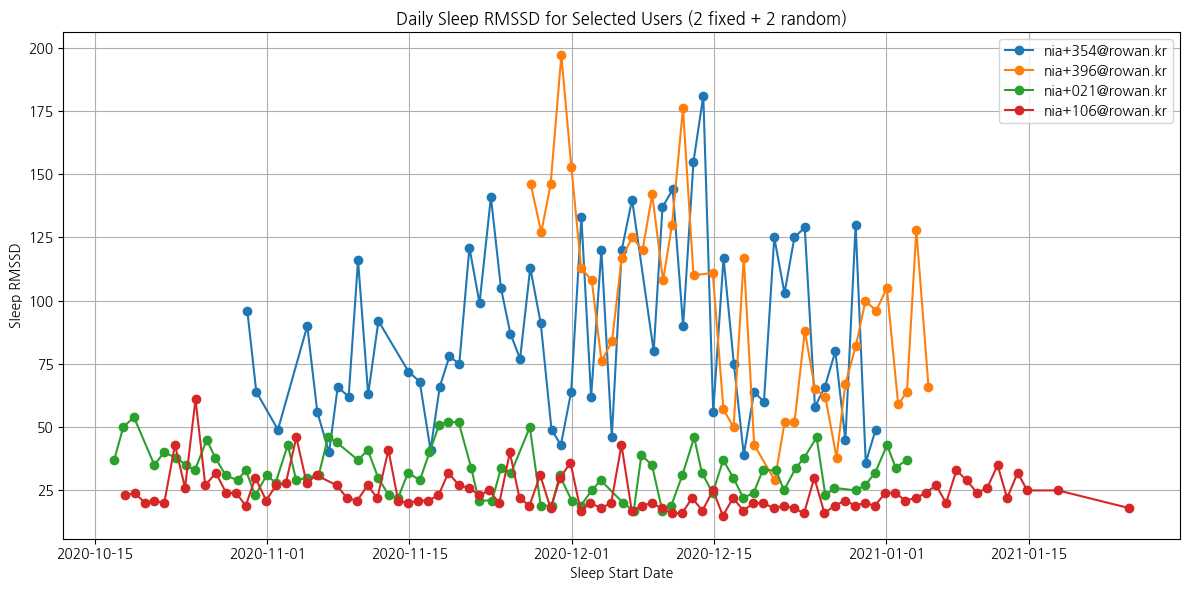

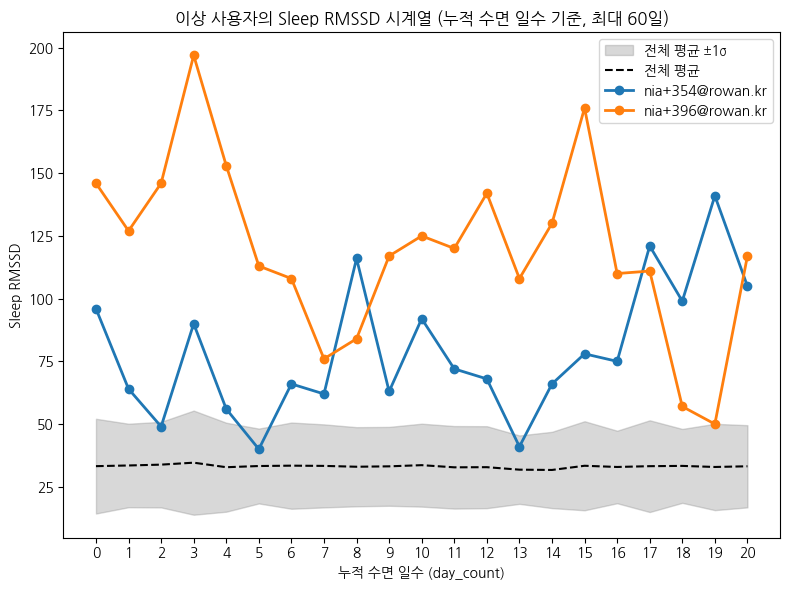

In [23]:
# 1. 사용자별 누적 일수 계산
sleep_train_eda = merged_train.sort_values(["EMAIL", "sleep_bedtime_start"]).copy()
sleep_train_eda["day_count"] = sleep_train_eda.groupby("EMAIL").cumcount()

# 2. 전체 사용자 기준 평균 / 표준편차 계산 (day_count 기준)
agg_df = sleep_train_eda.groupby("day_count")["sleep_rmssd"].agg(["mean", "std"]).reset_index()
agg_df = agg_df[agg_df["day_count"] < 21]  # ✅ 60일 이하만 필터링
agg_df["upper"] = agg_df["mean"] + agg_df["std"]
agg_df["lower"] = agg_df["mean"] - agg_df["std"]

# 3. 이상자 리스트
anomalous_emails = ["nia+354@rowan.kr", "nia+396@rowan.kr"]

# 4. 시각화
plt.figure(figsize=(8, 6))

# 전체 평균 ± 1σ 시각화
plt.fill_between(agg_df["day_count"], agg_df["lower"], agg_df["upper"], color="gray", alpha=0.3, label="전체 평균 ±1σ")
plt.plot(agg_df["day_count"], agg_df["mean"], color="black", linestyle="--", linewidth=1.5, label="전체 평균")

# 이상자별 시각화 (60일 이하로 필터링)
for email in anomalous_emails:
    user_data = sleep_train_eda[(sleep_train_eda["EMAIL"] == email) & (sleep_train_eda["day_count"] < 21)]
    plt.plot(user_data["day_count"], user_data["sleep_rmssd"], marker='o', linewidth=2, label=email)


# ✅ X축 눈금을 정수로 설정
plt.xticks(ticks=range(0, 21, 1))


# 라벨링
plt.title("이상 사용자의 Sleep RMSSD 시계열 (누적 수면 일수 기준, 최대 60일)")
plt.xlabel("누적 수면 일수 (day_count)")
plt.ylabel("Sleep RMSSD")
plt.legend()
plt.tight_layout()
plt.show()

In [34]:
merged_train = merged_train[~merged_train['EMAIL'].isin(['nia+354@rowan.kr', 'nia+396@rowan.kr'])]

In [35]:
sleep_train.to_csv("./data/preprocessed/train/train_sleep_preprocessed.csv", index=False)
sleep_val.to_csv("./data/preprocessed/validation/validation_sleep_preprocessed.csv", index=False)
activity_train.to_csv("./data/preprocessed/train/train_activity_preprocessed.csv", index=False)
activity_val.to_csv("./data/preprocessed/validation/validation_activity_preprocessed.csv", index=False)
label_train.to_csv("./data/preprocessed/train/train_label_preprocessed.csv", index=False)
label_val.to_csv("./data/preprocessed/validation/validation_label_preprocessed.csv", index=False)
merged_val.to_csv("./data/preprocessed/validation/merged_preprocessed.csv", index=False)
merged_train.to_csv("./data/preprocessed/train/merged_preprocessed.csv", index=False)